**Định nghĩa 2 biến chứa đường dẫn tới 2 file train và test**

In [1]:
from sklearn.datasets import load_files
import numpy as np

train_dir = '../input/fruits/fruits-360_dataset/fruits-360/Training'
test_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test'

**Định nghĩa một class SimpleDatasetLoader được dùng cho việc load data và label tương ứng từ tập dataset. class sẽ nhận một danh sách các công đoạn preprocessing và tiến hành preprocess data **

In [2]:
import numpy as np
import cv2
import os
class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors
        # if the preprocessors are None, initialize them as an
        # empty list
        if self.preprocessors is None:
            self.preprocessors = []


    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []
        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming
            # that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)
                    # treat our processed image as a "feature vector"
                    # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1,
                len(imagePaths)))
                # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

**Định nghĩa class SimplePreprocessor thực hiện việc resize image lại với kích thước thích hợp**

In [3]:
import cv2

class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect
        # ratio
        return cv2.resize(image, (self.width, self.height),
        interpolation=self.inter)

**Download package imutils, sau đó import paths method để tiến hành load data**

In [4]:
!pip install imutils
import imutils
from imutils import paths

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=43e6215f9bc8b8172ad1e24f5d5d362d7dfb31e34db2bbf067b0e056a899ec92
  Stored in directory: /root/.cache/pip/wheels/27/4d/3a/6dcdf7c3ebc87bf1ae013d96c9cf060ccfe334bb5ee769f377
Successfully built imutils


**Class ImageToArrayPreprocessor thực hiện việc chuyền đổi image sang một numpy array**

In [5]:
from tensorflow.keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        # store the image data format
        self.dataFormat = dataFormat
    def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges
        # the dimensions of the image
        return img_to_array(image, data_format=self.dataFormat)

**Tiến hành load data từ disk, trộn file data, sau đó khởi tạo 2 class SimplePreprocessor và ImageToArrayPreprocessor, kích thước ảnh được điều chỉnh lại thành 32x32, dùng SimpleDatasetLoader để preprocess sau đó load data và label**

In [6]:
train_imagePaths = list(paths.list_images(train_dir))
np.random.shuffle(train_imagePaths)
test_imagePaths = list(paths.list_images(test_dir))
np.random.shuffle(test_imagePaths)

sp = SimplePreprocessor(32,32)
iap = ImageToArrayPreprocessor()

dataloader = SimpleDatasetLoader(preprocessors = [sp, iap])
trainData, trainLabels = dataloader.load(train_imagePaths)
testData, testLabels = dataloader.load(test_imagePaths)

In [7]:
no_of_classes = len(np.unique(trainLabels))
print('Number of classes', no_of_classes)
print('Training set size', trainData.shape[0])
print('Testing set size', testData.shape[0])

Number of classes 120
Training set size 60498
Testing set size 20622


In [8]:
trainData = trainData.astype('float32')/255.0
testData = testData.astype('float32')/255.0

**Chuyển label sang dạng one-hot**

In [9]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
trainLabels = lb.fit_transform(trainLabels)
testLabels = lb.fit_transform(testLabels)

In [10]:
print(trainLabels[0:10])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
print('Training set shape', trainData.shape)
print('Testing set shape', testData.shape)

Training set shape (60498, 32, 32, 3)
Testing set shape (20622, 32, 32, 3)


In [12]:
trainData[0]

array([[[0.99607843, 0.99607843, 1.        ],
        [0.99607843, 1.        , 0.99607843],
        [0.99607843, 1.        , 0.99607843],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.9843137 , 1.        , 0.99607843],
        [0.99607843, 1.        , 1.        ],
        [1.        , 0.99607843, 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 0.99607843],
        [1.        , 0.99607843, 1.        ],
        [0.99607843, 0.99607843, 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

**Hiển thị 10 ảnh đầu trong tập training**

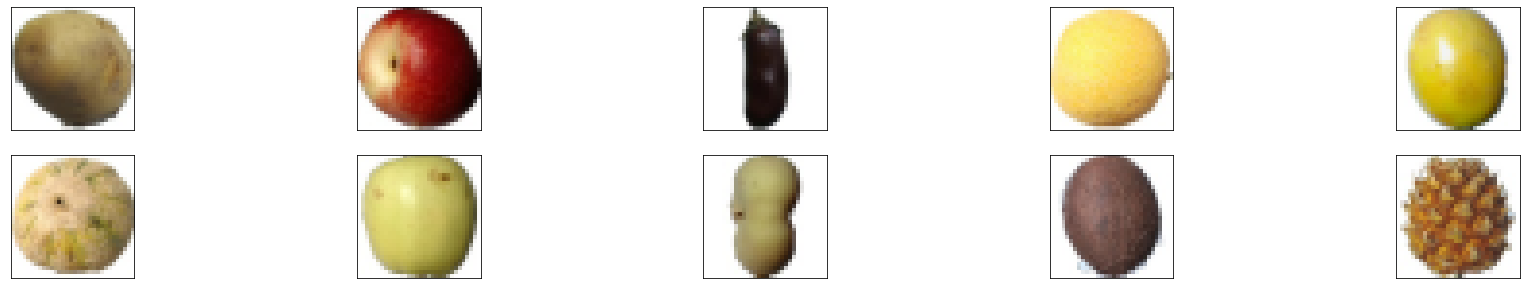

In [13]:
import matplotlib.pyplot as plt
import cv2
fig = plt.figure(figsize = (30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks = [], yticks = [])
    image = cv2.cvtColor(trainData[i], cv2.COLOR_BGR2RGB)
    ax.imshow(np.squeeze(image))

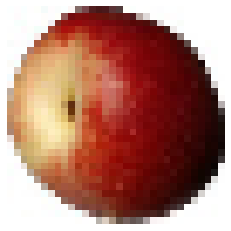

Nectarine


In [14]:
import matplotlib.image as mpimg

image = mpimg.imread(train_imagePaths[1])
image = imutils.resize(image, width = 32, inter = cv2.INTER_CUBIC)
plt.imshow(image)
imgplot = plt.imshow(image)
plt.axis('off')
plt.show()

labelNames = np.array([train_imagePath.split(os.path.sep)[-2] for train_imagePath in train_imagePaths])
print(labelNames[1])

**Định nghĩa model có tên là MiniVGGNet, dựa trên kiến trúc của model VGG16**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",
        input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=-1))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=-1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=-1))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=-1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        # return the constructed network architecture
        return model

**Tiến hành định nghĩa hàm optimizer ta sử dung SGD, thêm tùy chọn learning rate decay, sau đó gọi model MiniVGGNet và compile, chúng ta cũng sẽ tiến hành thêm một thí nghiêm với việc sử dụng LearningRateScheduler với hàm decay tự định nghĩa để so sánh với model này sau**

In [16]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=no_of_classes)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath = 'minivggnet_fruits.hdf5', verbose = 1, save_best_only = True)

In [18]:
H = model.fit(trainData, trainLabels, validation_data=(testData, testLabels), batch_size=64, callbacks = [checkpointer], epochs=10, verbose=1)

Train on 60498 samples, validate on 20622 samples
Epoch 1/10
60352/60498 [============================>.] - ETA: 0s - loss: 0.4930 - accuracy: 0.8739
Epoch 00001: val_loss improved from inf to 0.84336, saving model to minivggnet_fruits.hdf5
60498/60498 [==============================] - 15s 241us/sample - loss: 0.4922 - accuracy: 0.8740 - val_loss: 0.8434 - val_accuracy: 0.7747
Epoch 2/10
60096/60498 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9870
Epoch 00002: val_loss improved from 0.84336 to 0.09147, saving model to minivggnet_fruits.hdf5
60498/60498 [==============================] - 10s 158us/sample - loss: 0.0552 - accuracy: 0.9870 - val_loss: 0.0915 - val_accuracy: 0.9751
Epoch 3/10
60288/60498 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9937
Epoch 00003: val_loss improved from 0.09147 to 0.08240, saving model to minivggnet_fruits.hdf5
60498/60498 [==============================] - 9s 148us/sample - loss: 0.0298 - accuracy:

In [19]:
model.load_weights('minivggnet_fruits.hdf5')

In [20]:
labelNames = np.array([test_imagePath.split(os.path.sep)[-2] for test_imagePath in test_imagePaths])

In [21]:
print(np.unique(labelNames))

['Apple Braeburn' 'Apple Crimson Snow' 'Apple Golden 1' 'Apple Golden 2'
 'Apple Golden 3' 'Apple Granny Smith' 'Apple Pink Lady' 'Apple Red 1'
 'Apple Red 2' 'Apple Red 3' 'Apple Red Delicious' 'Apple Red Yellow 1'
 'Apple Red Yellow 2' 'Apricot' 'Avocado' 'Avocado ripe' 'Banana'
 'Banana Lady Finger' 'Banana Red' 'Beetroot' 'Blueberry' 'Cactus fruit'
 'Cantaloupe 1' 'Cantaloupe 2' 'Carambula' 'Cauliflower' 'Cherry 1'
 'Cherry 2' 'Cherry Rainier' 'Cherry Wax Black' 'Cherry Wax Red'
 'Cherry Wax Yellow' 'Chestnut' 'Clementine' 'Cocos' 'Dates' 'Eggplant'
 'Ginger Root' 'Granadilla' 'Grape Blue' 'Grape Pink' 'Grape White'
 'Grape White 2' 'Grape White 3' 'Grape White 4' 'Grapefruit Pink'
 'Grapefruit White' 'Guava' 'Hazelnut' 'Huckleberry' 'Kaki' 'Kiwi'
 'Kohlrabi' 'Kumquats' 'Lemon' 'Lemon Meyer' 'Limes' 'Lychee' 'Mandarine'
 'Mango' 'Mango Red' 'Mangostan' 'Maracuja' 'Melon Piel de Sapo'
 'Mulberry' 'Nectarine' 'Nectarine Flat' 'Nut Forest' 'Nut Pecan'
 'Onion Red' 'Onion Red Peeled' '

In [22]:
from sklearn.metrics import classification_report

predictions = model.predict(testData, batch_size=64)
print(classification_report(testLabels.argmax(axis=1),predictions.argmax(axis=1), target_names=np.unique(labelNames)))

                     precision    recall  f1-score   support

     Apple Braeburn       0.83      0.76      0.79       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       1.00      0.99      0.99       164
     Apple Golden 2       0.81      1.00      0.89       164
     Apple Golden 3       0.99      1.00      1.00       161
 Apple Granny Smith       1.00      1.00      1.00       164
    Apple Pink Lady       1.00      1.00      1.00       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       1.00      1.00      1.00       164
        Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      1.00      1.00       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

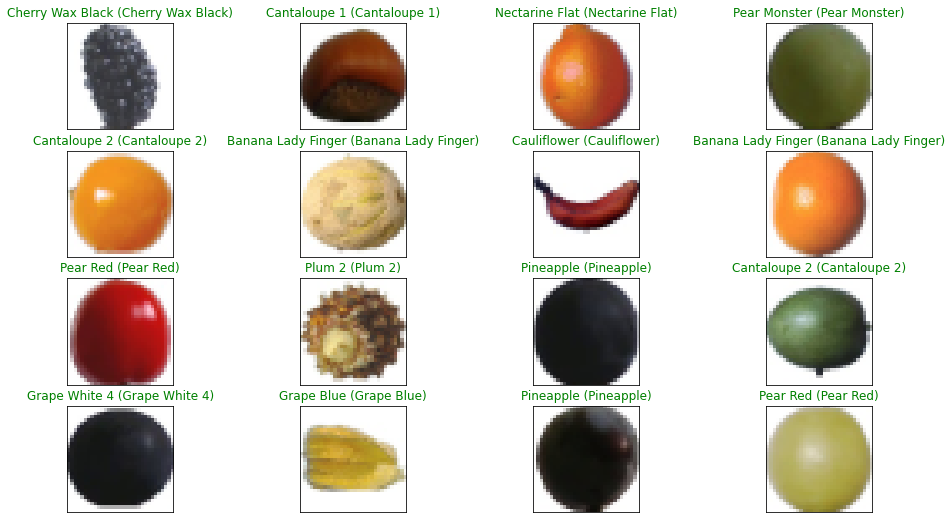

In [23]:
import cv2

fig = plt.figure(figsize = (16,9))
np.random.seed(42)
for i, idx in enumerate(np.random.choice(testData.shape[0], size = 16, replace = False)):
    ax = fig.add_subplot(4,4,i+1,xticks = [],yticks = [])
    image = cv2.cvtColor(testData[i], cv2.COLOR_BGR2RGB)
    ax.imshow(np.squeeze(image))
    pred_idx = np.argmax(predictions[idx])
    true_idx = np.argmax(testLabels[idx])
    ax.set_title('{} ({})'.format(labelNames[pred_idx], labelNames[true_idx]), color = ('green' if pred_idx == true_idx else 'red'))
    

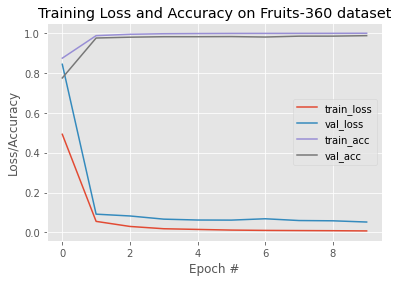

In [24]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H.history["loss"], label="train_loss")

plt.plot(np.arange(0, 10), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Fruits-360 dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

**Ta tiến hành train một model mới, không có nhiều khác biệt với model trước, lần này ta sẽ sử dụng LearningRateScheduler để gọi hàm step_decay tự định nghĩa, và so sánh kết quả giữa 2 model này**

In [29]:
from tensorflow.keras.optimizers import SGD

opt = SGD(lr = 0.01, momentum = 0.9, nesterov = True)
model_2 = MiniVGGNet.build(width=32, height=32, depth=3, classes=no_of_classes)
model_2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


**Định nghĩa hàm step_decay**

In [26]:
 def step_decay(epoch):
        # initialize the base initial learning rate, drop factor, and
        # epochs to drop every
        initAlpha = 0.01
        factor = 0.25
        dropEvery = 5
        # compute learning rate for the current epoch
        alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
        # return the learning rate
        return float(alpha)

In [30]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

checkpointer_2 = ModelCheckpoint(filepath = 'minivggnet_fruits_2.hdf5', verbose = 1, save_best_only = True)
callbacks = [LearningRateScheduler(step_decay), checkpointer_2]

H = model_2.fit(trainData, trainLabels, validation_data=(testData, testLabels), batch_size=64, epochs=10, callbacks=callbacks, verbose=1)

Train on 60498 samples, validate on 20622 samples
Epoch 1/10
60288/60498 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.8798
Epoch 00001: val_loss improved from inf to 0.14505, saving model to minivggnet_fruits_2.hdf5
60498/60498 [==============================] - 10s 171us/sample - loss: 0.4732 - accuracy: 0.8801 - val_loss: 0.1451 - val_accuracy: 0.9555
Epoch 2/10
60352/60498 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9876
Epoch 00002: val_loss improved from 0.14505 to 0.08068, saving model to minivggnet_fruits_2.hdf5
60498/60498 [==============================] - 9s 147us/sample - loss: 0.0500 - accuracy: 0.9876 - val_loss: 0.0807 - val_accuracy: 0.9778
Epoch 3/10
60160/60498 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9956
Epoch 00003: val_loss improved from 0.08068 to 0.07858, saving model to minivggnet_fruits_2.hdf5
60498/60498 [==============================] - 9s 148us/sample - loss: 0.0224 - accu

In [31]:
model_2.load_weights('minivggnet_fruits_2.hdf5')

In [33]:
from sklearn.metrics import classification_report

predictions = model_2.predict(testData, batch_size=64)
print(classification_report(testLabels.argmax(axis=1), predictions.argmax(axis=1), target_names=np.unique(labelNames)))

                     precision    recall  f1-score   support

     Apple Braeburn       0.83      0.85      0.84       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       0.99      0.99      0.99       164
     Apple Golden 2       0.89      1.00      0.94       164
     Apple Golden 3       0.86      1.00      0.93       161
 Apple Granny Smith       1.00      0.98      0.99       164
    Apple Pink Lady       1.00      1.00      1.00       152
        Apple Red 1       1.00      1.00      1.00       164
        Apple Red 2       0.96      1.00      0.98       164
        Apple Red 3       1.00      1.00      1.00       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      1.00      1.00       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    

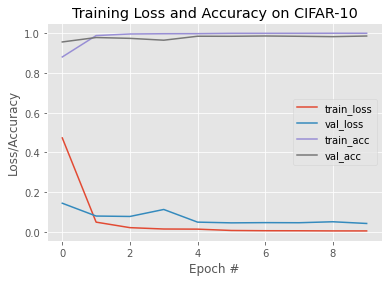

In [35]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()